In [2]:
from collections import defaultdict
import json
import os
import sys
import time

from scipy import stats
from scipy.stats import mannwhitneyu, wilcoxon
import numpy as np
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
from ete3 import PhyloTree
# from rna_tools.SecondaryStructure import parse_vienna_to_pairs
import seaborn as sns
import tqdm
import seqlogo

sys.path.append('../src/')
from mutations_extractor_with_context import get_sequence, node_parent, read_fasta_generator

In [3]:
REFSEQ_PATH = "../data/covid_ref.fasta"
SUBSTITUTIONS_PATH = "../data/overall_mutations_with_context2.json"
SEC_STRUCT_PATH_from_site = "../data/structure_data/SARSCoV2-RNA_from_site_plus_0based.ss"
# DISTANCES_PATH = "../data/new_final_fantasy_Tue_Apr_27_17:56:08_2021.csv"
DISTANCES_PATH = "../data/new_final_fantasy_Sat_May__8_13:54:58_2021.csv"
GENES_ANNOT_PATH = "../data/genes_annotation.csv"
FULL_ANNOT_PATH = '../data/full_gisaid_substitutions_annotation.csv'

### Substitution types (stype):
~~~
{
    0: комплементарные замены, приводящие к форм-ию компл. взаимодействий (ref+, parent-, child+)
    1: некомпл. замены, разрушающие уже имеющиеся компл. взаимодействия (ref+, parent+, child-)
    2: замены, которые не восстанавливают компл. взаимодействия (ref+, parent-, child-)
    3: вне вторичных взаимодействий в референсе (ref-)
    4: компл., заново сформированные за 1 итерацию (ref+, parent+, child+) paired substitutions
}
~~~

### Count wobble base-pairs 

In [4]:
_df = pd.read_csv('../data/secondary_structure_on_genome.csv')
_df['SsPairs'] += 1

In [5]:
s = []
d = _df[_df.IsStem == 1]
for pos1, n1, _, _, pos2 in d.values:
    pos2 = int(pos2)
    n2 = d[d.Pos == pos2].RefNuc.item()
    if not ({n1, n2} == set('AT') or {n1, n2} == set('GC')):
#         print(pos1, n1, pos2, n2)
        s.append((n1, n2))

In [6]:
np.unique(s, axis=0, return_counts=True)

(array([['A', 'C'],
        ['C', 'A'],
        ['G', 'T'],
        ['T', 'G']], dtype='<U1'),
 array([  1,   1, 249, 249]))

In [16]:
# number of pos with known ss
_df[_df.IsStem.isin([0,1])].shape

(6081, 5)

In [17]:
nfree = _df[_df.IsStem == 0].shape[0]

In [24]:
# strong: GC
# weak: AT, GT
_AT = {'A', 'T'}
_GT = {'G', 'T'}
_GC = {'G', 'C'}

nweak = nstrong = 0
for pos1, n1, _, _, pos2 in d.values:
    pos2 = int(pos2)
    n2 = d[d.Pos == pos2].RefNuc.item()
    pair = {n1, n2}
    if pair == _GC:
        nstrong += 1
    elif pair == _AT or pair == _GT:
        nweak += 1
    else:
        print(pos1, pos2, n1, n2)
    
assert nstrong + nweak == d.shape[0] - 2  # one CA

14408 14413 C A
14413 14408 A C


In [25]:
nstrong + nweak, d.shape[0]

(4220, 4222)

In [36]:
np.array([nfree, nstrong, nweak]) / (nstrong + nweak + nfree)

array([0.30580688, 0.28524428, 0.40894884])

In [35]:
pd.DataFrame(
    [np.round(np.array([nfree, nstrong, nweak]) / (nstrong + nweak + nfree), 2)], 
    columns=['free', 'strong', 'weak'],
    index = ['reference genome state'],
)

,free,strong,weak
reference genome state,0.31,0.29,0.41


------------

In [7]:
full_annotation = pd.read_csv(FULL_ANNOT_PATH)
full_annotation['n2n'] = full_annotation.parent_nucl + full_annotation.child_nucl

full_annotation = full_annotation[
    (full_annotation.child_nucl != '-') & (full_annotation.parent_nucl != '-')
]

assert np.sum(full_annotation.child_nucl == '-') == 0
assert np.sum(full_annotation.parent_nucl == '-') == 0

In [8]:
distances = pd.read_csv(DISTANCES_PATH)
distances['n2n'] = distances.parent_nucl + distances.child_nucl

genes_annot = pd.read_csv(GENES_ANNOT_PATH)
genes_annot['Pos'] -= 1

assert len(set(distances.pos.unique()).difference(genes_annot.Pos.unique())) == 0
distances = pd.merge(distances, genes_annot, left_on='pos', right_on='Pos')

# no need to filter on distance, we play with stype!
# distances = distances[distances.primary_dist2nearest < 30_000]
print(distances.shape)
distances.head(2)

(606936, 13)


,pair_idx,pos,parent_nucl,child_nucl,stype,primary_dist2nearest,secondary_dist2nearest,parent_node,child_node,n2n,Pos,RefNuc,GenName
0,0,240,C,T,0,30000,30000,#54567#,#51858#,CT,240,C,5UTR
1,1,240,C,T,0,30000,30000,#54567#,#54566#,CT,240,C,5UTR


In [14]:
stype_annot = {   
        0: "no info",
        1: "free>free",
        2: "free>weak",
        3: "free>strong",
        4: "weak>free",
        5: "weak>weak",
        6: "weak>strong",
        7: "strong>free",
        8: "strong>weak",
        9: "strong>strong",
}
_d = distances.stype.value_counts(sort=False).reset_index()
_d.columns = ['stype', 'count']
_d['stype'] = _d.stype.map(stype_annot)
_d

,stype,count
0,no info,533834
1,free>free,287
2,free>weak,6339
3,free>strong,11190
4,weak>free,7062
5,weak>weak,10040
6,weak>strong,12607
7,strong>free,12764
8,strong>weak,12813


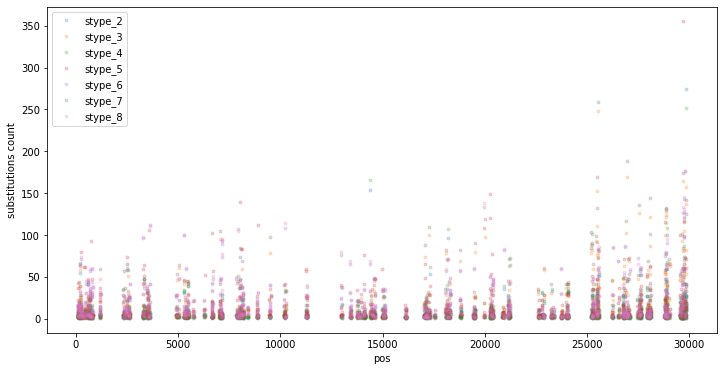

In [34]:
plt.figure(figsize=(12, 6))

for i in range(2, 9):
    plt.plot(
        distances[distances.stype == i].pos.value_counts().index, 
        distances[distances.stype == i].pos.value_counts().values,
        '.', alpha=.2, label=f'stype_{i}'
    )
plt.ylabel('substitutions count')
plt.xlabel('pos')
plt.legend()
plt.show()

In [37]:
stype_on_pos.columns.map(stype_annot)

Index(['no info', 'free>free', 'free>weak', 'free>strong', 'weak>free',
       'weak>weak', 'weak>strong', 'strong>free', 'strong>weak'],
      dtype='object', name='stype')

In [38]:
_stype_on_pos = distances.groupby(['pos', 'stype'])['pair_idx'].count().reset_index()
_stype_on_pos.columns = ['pos', 'stype', 'count']

stype_on_pos = pd.pivot_table(_stype_on_pos, index='pos', columns='stype', values='count', fill_value=0)
# stype_on_pos.columns = [f"stype_{x}" for x in stype_on_pos.columns]
stype_on_pos.columns = stype_on_pos.columns.map(stype_annot)

# stype_on_pos.to_csv('../data/stype_on_pos.csv')

In [39]:
_d2 = stype_on_pos.sum(axis=0).reset_index()
_d2.columns = ['stype', 'number']
_d2

,stype,number
0,no info,533834
1,free>free,287
2,free>weak,6339
3,free>strong,11190
4,weak>free,7062
5,weak>weak,10040
6,weak>strong,12607
7,strong>free,12764
8,strong>weak,12813


In [164]:
didi = dict(_d2.values)
matrix = np.array([
    [didi['free>free'], didi['free>strong'], didi['free>weak']],
    [didi['strong>free'], didi.get('strong>strong', 0), didi['strong>weak']],
    [didi['weak>free'], didi['weak>strong'], didi['weak>weak']],
])
(matrix / matrix.sum(axis=1).reshape(-1, 1)).round(3)

array([[0.016, 0.628, 0.356],
       [0.499, 0.   , 0.501],
       [0.238, 0.424, 0.338]])

[link](http://markov.yoriz.co.uk/)
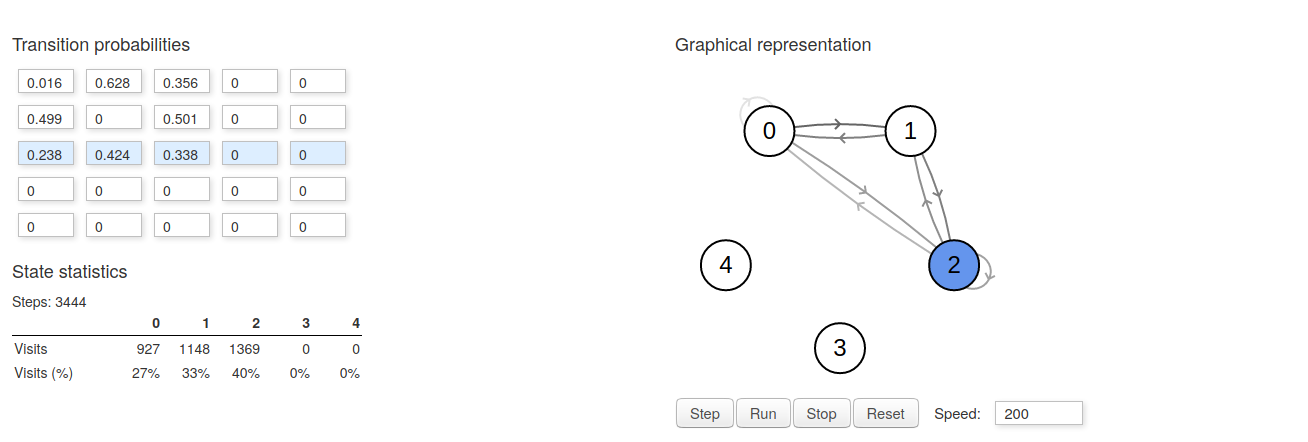

In [140]:
pd.read_csv('../data/ref_annot.csv').RefNuc.value_counts()

T    9594
A    8954
G    5863
C    5492
Name: RefNuc, dtype: int64

In [137]:
12700 / (12800+12700)

0.4980392156862745

In [130]:
12764 + 7062, 11190 + 6339

(19826, 17529)

In [40]:
def context_extraction(full_annotation, mut='CT'):
    # https://github.com/betteridiot/seqlogo
    full_annotation = full_annotation.copy()[full_annotation.parent_nucl_context.str.len() == 5]
    gr = full_annotation.groupby('n2n')
    substitutions = gr.get_group(mut)
    
    mean_context = []
    
    for i in range(5):  # context index
        one_mut_context = substitutions.parent_nucl_context.apply(
            lambda s: s[i]).value_counts(normalize=True).to_dict()

        # filter freqs
        if i != 2:
            one_mut_context = {nucl: share for nucl, share in one_mut_context.items() if nucl in 'actg'}
        else:
            one_mut_context = {nucl.lower(): share for nucl, share in one_mut_context.items() if share > .95}
            assert len(one_mut_context) == 1
            
        mut_ppm = np.array([one_mut_context.get(nucl, 0) for nucl in 'acgt'])
        mut_ppm = mut_ppm / mut_ppm.sum()
#         assert mut_ppm.sum() == 1, f' == {mut_ppm.sum()}'
        mean_context.append(mut_ppm)
        
    return np.array(mean_context)

In [118]:
def calculate_stype_on_pos(distances, mut=['all'], gene_names=['all']):
    distances = distances[distances.stype != 0]
    if mut != ['all']:
        distances = distances[distances['n2n'].isin(mut)]
    if gene_names != ['all']:
        distances = distances[distances['GenName'].isin(gene_names)]
    
    _stype_on_pos = distances.groupby(['pos', 'stype'])['pair_idx'].count().reset_index()
    _stype_on_pos.columns = ['pos', 'stype', 'count']

    stype_on_pos = pd.pivot_table(_stype_on_pos, index='pos', columns='stype', values='count', fill_value=0)
#     stypes = ['free2paired', 'paired2free', 'free2free', 'no_info', 'paired2paired']
#     idx_accordance = {i: v for i, v in enumerate(stypes)}
    # add zero values
    for col in range(1, 9):
        if col not in stype_on_pos.columns:
            stype_on_pos[col] = 0
            
    stype_on_pos.columns = stype_on_pos.columns.map(stype_annot)
    
    if stype_on_pos.shape[0] < 10:
        return None
    return stype_on_pos


def count_difference(stype_on_pos, fea1, fea2, plot=False):
    # fea1 - fea2
    difference = stype_on_pos[fea1] - stype_on_pos[fea2]
    if plot:
        difference.plot.hist(bins=40)
        plt.title('Distribution of destabilizing-stabilizing substitutions difference')
        plt.xlabel(f'{fea1} - {fea2}')
        plt.show()
        
    w, pval = wilcoxon(
        stype_on_pos[fea1], 
        stype_on_pos[fea2], 
    )
    return difference.mean(), w, pval

In [120]:
genes = distances.GenName.unique()
genes = np.concatenate([['all'], genes])

fea1, fea2 = 'weak>strong', 'strong>weak'

gstat_table = []
for gene in genes:
    stype_on_pos = calculate_stype_on_pos(distances, gene_names=[gene])
    if stype_on_pos is None:
        continue
    _cols = stype_on_pos.columns
    if fea1 not in _cols or fea2 not in _cols:
        continue
    average, w, pval = count_difference(stype_on_pos, fea1, fea2)
    significant = '+' if pval < .05 else '-'
    gstat_table.append((gene, stype_on_pos.sum().sum(), average, w, pval, significant))

_cols = ['gene', 'subst_count', 'diff_mean', 'w_statistic', 'p_value', 'significant']
gstat_table = pd.DataFrame(gstat_table, columns=_cols)

/home/mr/.local/lib/python3.7/site-packages/scipy/stats/morestats.py:2981: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/home/mr/.local/lib/python3.7/site-packages/scipy/stats/morestats.py:2967: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/home/mr/.local/lib/python3.7/site-packages/scipy/stats/morestats.py:2981: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/home/mr/.local/lib/python3.7/site-packages/scipy/stats/morestats.py:2981: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/home/mr/.local/lib/python3.7/site-packages/scipy/stats/morestats.py:2967: UserWarning: Exact p-value calculation does not work if there 

In [121]:
# .iloc[[0, 1, 2, 6, 7, 10, 8, 3, 4, 9, 5]]
gstat_table.round({'diff_mean': 2})

,gene,subst_count,diff_mean,w_statistic,p_value,significant
0,all,73102,-0.08,25141.0,1.962040e-08,+
1,5UTR,2482,-0.06,60.5,4.293502e-01,-
2,ORF1ab,36295,-0.07,9897.0,3.315820e-06,+
3,ORF8,2432,-0.03,12.0,7.257210e-01,-
4,N,5232,-0.06,80.0,5.300905e-01,-
5,3UTR,8129,-0.19,52.0,2.377469e-01,-
6,E,292,0.10,0.0,3.173105e-01,-
7,S,5116,-0.01,169.5,6.220544e-01,-
8,ORF3a,4471,-0.28,14.0,1.376078e-02,+
9,ORF7a,2493,-0.06,9.0,1.053715e-01,-


In [167]:
mutations = distances['n2n'].unique()
mutations = np.concatenate([['all'], mutations])

fea1, fea2 = 'free>strong', 'strong>free'

stat_table = []
for mut in mutations:
    stype_on_pos = calculate_stype_on_pos(distances, mut=[mut])
    if np.all(stype_on_pos[fea1] - stype_on_pos[fea2] == 0):
        stat_table.append([])
        continue
        
    average, w, pval = count_difference(stype_on_pos, fea1, fea2)
    significant = '+' if pval < .05 else '-'
    stat_table.append((mut, stype_on_pos.sum().sum(), average, w, pval, significant))
#     print(f'{mut}: {stype_on_pos.sum().sum()} substitutions')
#     print(f'mean = {average: .2f}, pvalue = {pval:.2e}')

_cols = ['subst', 'subst_count', 'diff_mean', 'w_statistic', 'p_value', 'significant']
stat_table = pd.DataFrame(stat_table, columns=_cols)

/home/mr/.local/lib/python3.7/site-packages/scipy/stats/morestats.py:2981: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


In [168]:
stat_table.round({'diff_mean': 2}).sort_values('subst')

,subst,subst_count,diff_mean,w_statistic,p_value,significant
5,AC,1280.0,2.56,0.0,1.127532e-35,+
8,AG,7902.0,2.84,0.0,2.112990e-62,+
6,CA,1270.0,-2.99,0.0,1.477644e-35,+
11,CG,681.0,2.70,1270.5,1.069205e-05,+
1,CT,15454.0,-0.07,0.0,7.598775e-04,+
7,GA,8365.0,-2.93,0.0,2.458068e-75,+
12,GC,667.0,-3.18,838.5,2.907590e-06,+
10,GT,10012.0,-12.70,0.0,7.857668e-70,+
2,TC,15636.0,0.03,0.0,2.728117e-02,+
9,TG,8707.0,11.81,0.0,2.271658e-64,+


In [156]:
# write logos to files
mut_context_path = '../visual_data/mut_context/'
for mut in mutations[1:]:
    mut_ppm = context_extraction(full_annotation, mut)
    ppm = seqlogo.Ppm(mut_ppm)
    path = mut_context_path + mut + '.png'
    seqlogo.seqlogo(ppm, ic_scale = False, format = 'png', size = 'small', filename=path)

### Table with logos

context | subst | subst_count | (n_destab - n_stab)_mean | destabilize | w_statistic | p_value | significant |
------- | ----- | ----------- | --------- | ------------- | ----------- | ------- | ----------- | 
<img src="../visual_data/mut_context/AC.png-130x.jpg" width="120"/> | A>C    |     710    |   -2.78    | - |      528.5 | 2.1e-01    |  -
<img src="../visual_data/mut_context/AG.png-130x.jpg" width="120"/> | A>G    |     6196   |     4.29   | + |    26177.0 | 9.9e-07    |  +
<img src="../visual_data/mut_context/AT.png-130x.jpg" width="120"/>  | A>T    |      942   |   -2.73    | - |      538.0 | 6.1e-01    |  -
<img src="../visual_data/mut_context/CA.png-130x.jpg" width="120"/>  | C>A    |      717   |    3.15    | + |     485.5  | 2.9e-01    |  -
<img src="../visual_data/mut_context/CG.png-130x.jpg" width="120"/>  | C>G    |      333   |  -23.00    | - |       8.0  | 2.4e-02    |  +
<img src="../visual_data/mut_context/CT.png-130x.jpg" width="120"/>  | C>T    |    14117   |    16.73   | + |   27817.5  | 9.9e-53    |  +
<img src="../visual_data/mut_context/GA.png-130x.jpg" width="120"/>  | G>A    |     6452   |    -3.56   | - |   30811.0  | 7.9e-05    |  +
<img src="../visual_data/mut_context/GC.png-130x.jpg" width="120"/>  | G>C    |      340   |    21.83   | + |       9.0  | 1.6e-02    |  +
<img src="../visual_data/mut_context/GT.png-130x.jpg" width="120"/>  | G>T    |     7672   |    30.41   | + |     739.5  | 4.1e-38    |  +
<img src="../visual_data/mut_context/TA.png-130x.jpg" width="120"/>  | T>A    |      809   |     2.61   | + |     340.0  | 6.6e-01    |  -
<img src="../visual_data/mut_context/TC.png-130x.jpg" width="120"/>  | T>C    |   14128    |  -15.46    | - |   33694.5  | 2.0e-48    |  +
<img src="../visual_data/mut_context/TG.png-130x.jpg" width="120"/>  | T>G    |     6602   |  -28.88    | - |   726.0    | 1.1e-33    |  +
 | all   |     68351  |   1.10   | + |  121694.0 | 3.4e-88    |  +

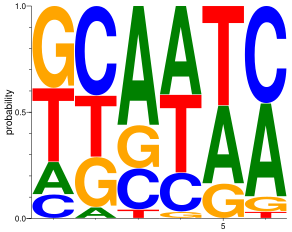

In [94]:
random_ppm = np.random.dirichlet(np.ones(4), size=6)

ppm = seqlogo.Ppm(random_ppm)
seqlogo.seqlogo(ppm, ic_scale = False, format = 'svg', size = 'small')

In [16]:
distances.head()

,pair_idx,pos,parent_nucl,child_nucl,stype,primary_dist2nearest,secondary_dist2nearest,parent_node,child_node,n2n,Pos,RefNuc,GenName
0,0,240,C,T,3,30000,30000,#54567#,#51858#,CT,240,C,5UTR
1,1,240,C,T,3,30000,30000,#54567#,#54566#,CT,240,C,5UTR
2,758,240,T,C,3,30000,30000,#48888#,#48203#,TC,240,C,5UTR
3,1028,240,C,T,3,30000,30000,#48203#,#47426#,CT,240,C,5UTR
4,1029,240,C,T,3,30000,30000,#48203#,#39588#,CT,240,C,5UTR


In [41]:
filtered_stype_on_pos = calculate_stype_on_pos(distances)
filtered_stype_on_pos.head(2)

stype,free2paired,paired2free,free2free,no_info,paired2paired
pos,,,,,
83,10,10,0,0,0
87,8,7,0,0,0


In [45]:
filtered_stype_on_pos

stype,free2paired,paired2free,free2free,no_info,paired2paired
pos,,,,,
83,10,10,0,0,0
87,8,7,0,0,0
89,8,8,0,0,0
90,18,19,24,0,0
93,6,8,0,0,0
...,...,...,...,...,...
29862,35,29,3,0,0
29863,137,125,4,0,0
29864,44,51,3,0,0


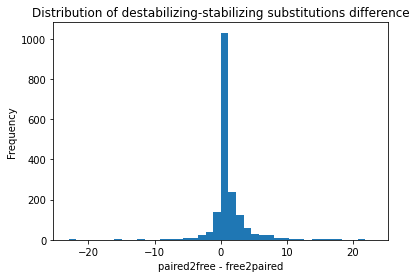

(1.100831024930748, 121694.0, 3.3458041901654024e-88)

In [12]:
count_difference(filtered_stype_on_pos, plot=True)

In [39]:
# trend to become paired or free
filtered_stype_on_pos[(division < .5) | (division > 2)].iloc[:, :3]

,free2paired,paired2free,free2free
pos,,,
159,6,15,0
171,2,5,0
268,3,7,0
8005,5,2,0
11290,6,2,0
13424,2,6,0
17241,5,2,1
19480,2,5,0
20355,2,7,0


In [40]:
# trend to jumb: free <--> paired
filtered_stype_on_pos[(division > .5) & (division < 2)].iloc[:, [0,1,2]]

,free2paired,paired2free,free2free
pos,,,
83,10,10,0
87,8,7,0
89,8,8,0
90,18,19,24
93,6,8,0
...,...,...,...
29862,35,29,3
29863,137,125,4
29864,44,51,3


In [1]:
# Они реально прыгают

In [12]:
# https://seaborn.pydata.org/tutorial/color_palettes.html
palette = sns.color_palette("hls", 5)
palette

[(0.86, 0.3712, 0.33999999999999997),
 (0.7247999999999999, 0.86, 0.33999999999999997),
 (0.33999999999999997, 0.86, 0.5792000000000002),
 (0.33999999999999997, 0.5167999999999995, 0.86),
 (0.7871999999999999, 0.33999999999999997, 0.86)]